In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/breakhis/train/'
test_dir = "data/breakhis/test/"

extracted_features_dir = "extracted_features/"
model_name = "BreakHis_3path_CNN"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/breakhis/train/ 0
data/breakhis/train/benign 36224
data/breakhis/train/malignant 79168
******************************
data/breakhis/test/ 0
data/breakhis/test/benign 216
data/breakhis/test/malignant 481


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 86544 images belonging to 2 classes.
Found 28848 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 86544
nb_validation_samples: 28848

predict_size_train: 2705
predict_size_validation: 902
nb_test_samples: 697
predict_size_test: 22

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  

base_model1=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=MobileNetV2(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

merge = concatenate([x1, x2, x3])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
c1 = model.layers[7].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[53].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[141].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[481].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[827].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[835].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[851].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[866].output
c8 = GlobalAveragePooling2D()(c8) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 86544 samples, validate on 28848 samples
Epoch 1/1000
 - 15s - loss: 0.4716 - acc: 0.7765 - val_loss: 0.3930 - val_acc: 0.8158
Epoch 2/1000
 - 12s - loss: 0.3556 - acc: 0.8519 - val_loss: 0.3188 - val_acc: 0.8629
Epoch 3/1000
 - 12s - loss: 0.3050 - acc: 0.8790 - val_loss: 0.2666 - val_acc: 0.8990
Epoch 4/1000
 - 12s - loss: 0.2786 - acc: 0.8902 - val_loss: 0.2643 - val_acc: 0.9047
Epoch 5/1000
 - 12s - loss: 0.2591 - acc: 0.8987 - val_loss: 0.2293 - val_acc: 0.9132
Epoch 6/1000
 - 12s - loss: 0.2448 - acc: 0.9042 - val_loss: 0.2407 - val_acc: 0.9088
Epoch 7/1000
 - 12s - loss: 0.2334 - acc: 0.9101 - val_loss: 0.2133 - val_acc: 0.9166
Epoch 8/1000
 - 12s - loss: 0.2239 - acc: 0.9126 - val_loss: 0.1975 - val_acc: 0.9257
Epoch 9/1000
 - 12s - loss: 0.2141 - acc: 0.9174 - val_loss: 0.1965 - val_acc: 0.9226
Epoch 10/1000
 - 12s - loss: 0.2057 - acc: 0.9203 - val_loss: 0.1804 - val_acc: 0.9309
Epoch 11/1000
 - 12s - loss: 0.1968 - acc: 0.9238 - val_loss: 0.1786 - val_acc: 0.9320
Ep

Epoch 95/1000
 - 12s - loss: 0.0587 - acc: 0.9783 - val_loss: 0.0454 - val_acc: 0.9836
Epoch 96/1000
 - 12s - loss: 0.0578 - acc: 0.9790 - val_loss: 0.0469 - val_acc: 0.9853
Epoch 97/1000
 - 12s - loss: 0.0586 - acc: 0.9786 - val_loss: 0.0511 - val_acc: 0.9835
Epoch 98/1000
 - 12s - loss: 0.0578 - acc: 0.9791 - val_loss: 0.0437 - val_acc: 0.9860
Epoch 99/1000
 - 12s - loss: 0.0574 - acc: 0.9790 - val_loss: 0.0476 - val_acc: 0.9832
Epoch 100/1000
 - 12s - loss: 0.0560 - acc: 0.9797 - val_loss: 0.0421 - val_acc: 0.9856
Epoch 101/1000
 - 12s - loss: 0.0559 - acc: 0.9794 - val_loss: 0.0530 - val_acc: 0.9798
Epoch 102/1000
 - 12s - loss: 0.0576 - acc: 0.9792 - val_loss: 0.0426 - val_acc: 0.9852
Epoch 103/1000
 - 12s - loss: 0.0544 - acc: 0.9802 - val_loss: 0.0430 - val_acc: 0.9846
Epoch 104/1000
 - 12s - loss: 0.0548 - acc: 0.9799 - val_loss: 0.0438 - val_acc: 0.9846
Epoch 105/1000
 - 12s - loss: 0.0538 - acc: 0.9804 - val_loss: 0.0457 - val_acc: 0.9834
Epoch 106/1000
 - 12s - loss: 0.0532 

 - 12s - loss: 0.0339 - acc: 0.9879 - val_loss: 0.0254 - val_acc: 0.9910
Epoch 189/1000
 - 12s - loss: 0.0338 - acc: 0.9880 - val_loss: 0.0366 - val_acc: 0.9854
Epoch 190/1000
 - 12s - loss: 0.0334 - acc: 0.9883 - val_loss: 0.0241 - val_acc: 0.9915
Epoch 191/1000
 - 12s - loss: 0.0333 - acc: 0.9884 - val_loss: 0.0251 - val_acc: 0.9911
Epoch 192/1000
 - 12s - loss: 0.0326 - acc: 0.9885 - val_loss: 0.0250 - val_acc: 0.9910
Epoch 193/1000
 - 12s - loss: 0.0324 - acc: 0.9884 - val_loss: 0.0356 - val_acc: 0.9867
Epoch 194/1000
 - 12s - loss: 0.0321 - acc: 0.9881 - val_loss: 0.0244 - val_acc: 0.9922
Epoch 195/1000
 - 12s - loss: 0.0322 - acc: 0.9888 - val_loss: 0.0270 - val_acc: 0.9912
Epoch 196/1000
 - 12s - loss: 0.0321 - acc: 0.9890 - val_loss: 0.0235 - val_acc: 0.9930
Epoch 197/1000
 - 12s - loss: 0.0323 - acc: 0.9889 - val_loss: 0.0296 - val_acc: 0.9889
Epoch 198/1000
 - 12s - loss: 0.0325 - acc: 0.9885 - val_loss: 0.0245 - val_acc: 0.9914
Epoch 199/1000
 - 12s - loss: 0.0307 - acc: 0.9

Epoch 282/1000
 - 12s - loss: 0.0233 - acc: 0.9923 - val_loss: 0.0153 - val_acc: 0.9947
Epoch 283/1000
 - 12s - loss: 0.0240 - acc: 0.9917 - val_loss: 0.0185 - val_acc: 0.9934
Epoch 284/1000
 - 12s - loss: 0.0240 - acc: 0.9917 - val_loss: 0.0171 - val_acc: 0.9948
Epoch 285/1000
 - 12s - loss: 0.0242 - acc: 0.9919 - val_loss: 0.0226 - val_acc: 0.9921
Epoch 286/1000
 - 12s - loss: 0.0225 - acc: 0.9923 - val_loss: 0.0166 - val_acc: 0.9943
Epoch 287/1000
 - 12s - loss: 0.0229 - acc: 0.9922 - val_loss: 0.0171 - val_acc: 0.9949
Epoch 288/1000
 - 12s - loss: 0.0232 - acc: 0.9920 - val_loss: 0.0191 - val_acc: 0.9936
Epoch 289/1000
 - 12s - loss: 0.0235 - acc: 0.9918 - val_loss: 0.0202 - val_acc: 0.9934
Epoch 290/1000
 - 12s - loss: 0.0215 - acc: 0.9928 - val_loss: 0.0181 - val_acc: 0.9935
Epoch 291/1000
 - 12s - loss: 0.0231 - acc: 0.9924 - val_loss: 0.0154 - val_acc: 0.9948
Epoch 292/1000
 - 12s - loss: 0.0229 - acc: 0.9921 - val_loss: 0.0156 - val_acc: 0.9950
Epoch 293/1000
 - 12s - loss: 0.

 - 12s - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0168 - val_acc: 0.9945
Epoch 376/1000
 - 12s - loss: 0.0174 - acc: 0.9943 - val_loss: 0.0132 - val_acc: 0.9958
Epoch 377/1000
 - 12s - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0143 - val_acc: 0.9944
Epoch 378/1000
 - 12s - loss: 0.0173 - acc: 0.9941 - val_loss: 0.0139 - val_acc: 0.9947
Epoch 379/1000
 - 12s - loss: 0.0183 - acc: 0.9938 - val_loss: 0.0185 - val_acc: 0.9930
Epoch 380/1000
 - 12s - loss: 0.0171 - acc: 0.9942 - val_loss: 0.0124 - val_acc: 0.9957
Epoch 381/1000
 - 12s - loss: 0.0179 - acc: 0.9940 - val_loss: 0.0151 - val_acc: 0.9944
Epoch 382/1000
 - 12s - loss: 0.0177 - acc: 0.9942 - val_loss: 0.0123 - val_acc: 0.9959
Epoch 383/1000
 - 12s - loss: 0.0162 - acc: 0.9948 - val_loss: 0.0131 - val_acc: 0.9953
Epoch 384/1000
 - 12s - loss: 0.0169 - acc: 0.9944 - val_loss: 0.0163 - val_acc: 0.9941
Epoch 385/1000
 - 12s - loss: 0.0174 - acc: 0.9943 - val_loss: 0.0135 - val_acc: 0.9951
Epoch 386/1000
 - 12s - loss: 0.0192 - acc: 0.9

Epoch 469/1000
 - 12s - loss: 0.0150 - acc: 0.9953 - val_loss: 0.0164 - val_acc: 0.9945
Epoch 470/1000
 - 12s - loss: 0.0148 - acc: 0.9952 - val_loss: 0.0103 - val_acc: 0.9962
Epoch 471/1000
 - 12s - loss: 0.0147 - acc: 0.9952 - val_loss: 0.0111 - val_acc: 0.9964
Epoch 472/1000
 - 12s - loss: 0.0144 - acc: 0.9956 - val_loss: 0.0100 - val_acc: 0.9964
Epoch 473/1000
 - 12s - loss: 0.0137 - acc: 0.9956 - val_loss: 0.0129 - val_acc: 0.9958
Epoch 474/1000
 - 12s - loss: 0.0144 - acc: 0.9953 - val_loss: 0.0112 - val_acc: 0.9959
Epoch 475/1000
 - 12s - loss: 0.0149 - acc: 0.9950 - val_loss: 0.0121 - val_acc: 0.9957
Epoch 476/1000
 - 12s - loss: 0.0141 - acc: 0.9954 - val_loss: 0.0123 - val_acc: 0.9957
Epoch 477/1000
 - 12s - loss: 0.0136 - acc: 0.9957 - val_loss: 0.0118 - val_acc: 0.9956
Epoch 478/1000
 - 12s - loss: 0.0139 - acc: 0.9954 - val_loss: 0.0129 - val_acc: 0.9954
Epoch 479/1000
 - 12s - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0123 - val_acc: 0.9954
Epoch 480/1000
 - 12s - loss: 0.

 - 12s - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0081 - val_acc: 0.9969
Epoch 563/1000
 - 12s - loss: 0.0123 - acc: 0.9959 - val_loss: 0.0098 - val_acc: 0.9967
Epoch 564/1000
 - 12s - loss: 0.0119 - acc: 0.9959 - val_loss: 0.0090 - val_acc: 0.9972
Epoch 565/1000
 - 12s - loss: 0.0126 - acc: 0.9957 - val_loss: 0.0095 - val_acc: 0.9969
Epoch 566/1000
 - 12s - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0092 - val_acc: 0.9971
Epoch 567/1000
 - 13s - loss: 0.0122 - acc: 0.9960 - val_loss: 0.0102 - val_acc: 0.9966
Epoch 568/1000
 - 12s - loss: 0.0127 - acc: 0.9959 - val_loss: 0.0102 - val_acc: 0.9963
Epoch 569/1000
 - 12s - loss: 0.0113 - acc: 0.9963 - val_loss: 0.0115 - val_acc: 0.9960
Epoch 570/1000
 - 12s - loss: 0.0128 - acc: 0.9960 - val_loss: 0.0101 - val_acc: 0.9967
Epoch 571/1000
 - 12s - loss: 0.0119 - acc: 0.9963 - val_loss: 0.0085 - val_acc: 0.9968
Epoch 572/1000
 - 12s - loss: 0.0115 - acc: 0.9963 - val_loss: 0.0091 - val_acc: 0.9971
Epoch 573/1000
 - 12s - loss: 0.0115 - acc: 0.9

Epoch 656/1000
 - 12s - loss: 0.0115 - acc: 0.9960 - val_loss: 0.0119 - val_acc: 0.9956
Epoch 657/1000
 - 12s - loss: 0.0103 - acc: 0.9966 - val_loss: 0.0085 - val_acc: 0.9973
Epoch 658/1000
 - 12s - loss: 0.0116 - acc: 0.9959 - val_loss: 0.0093 - val_acc: 0.9966
Epoch 659/1000
 - 12s - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0076 - val_acc: 0.9977
Epoch 660/1000
 - 12s - loss: 0.0112 - acc: 0.9961 - val_loss: 0.0087 - val_acc: 0.9971
Epoch 661/1000
 - 12s - loss: 0.0104 - acc: 0.9965 - val_loss: 0.0103 - val_acc: 0.9963
Epoch 662/1000
 - 12s - loss: 0.0106 - acc: 0.9965 - val_loss: 0.0089 - val_acc: 0.9976
Epoch 663/1000
 - 12s - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0090 - val_acc: 0.9968
Epoch 664/1000
 - 12s - loss: 0.0101 - acc: 0.9965 - val_loss: 0.0088 - val_acc: 0.9969
Epoch 665/1000
 - 12s - loss: 0.0105 - acc: 0.9965 - val_loss: 0.0092 - val_acc: 0.9965
Epoch 666/1000
 - 12s - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0114 - val_acc: 0.9956
Epoch 667/1000
 - 12s - loss: 0.

 - 13s - loss: 0.0093 - acc: 0.9972 - val_loss: 0.0078 - val_acc: 0.9971
Epoch 750/1000
 - 13s - loss: 0.0088 - acc: 0.9970 - val_loss: 0.0082 - val_acc: 0.9974
Epoch 751/1000
 - 13s - loss: 0.0093 - acc: 0.9970 - val_loss: 0.0075 - val_acc: 0.9975
Epoch 752/1000
 - 12s - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0079 - val_acc: 0.9972
Epoch 753/1000
 - 12s - loss: 0.0095 - acc: 0.9969 - val_loss: 0.0076 - val_acc: 0.9969
Epoch 754/1000
 - 12s - loss: 0.0096 - acc: 0.9969 - val_loss: 0.0076 - val_acc: 0.9976
Epoch 755/1000
 - 12s - loss: 0.0101 - acc: 0.9967 - val_loss: 0.0077 - val_acc: 0.9978
Epoch 756/1000
 - 12s - loss: 0.0097 - acc: 0.9970 - val_loss: 0.0084 - val_acc: 0.9970
Epoch 757/1000
 - 12s - loss: 0.0089 - acc: 0.9970 - val_loss: 0.0097 - val_acc: 0.9966
Epoch 758/1000
 - 12s - loss: 0.0091 - acc: 0.9972 - val_loss: 0.0084 - val_acc: 0.9970
Epoch 759/1000
 - 12s - loss: 0.0095 - acc: 0.9970 - val_loss: 0.0095 - val_acc: 0.9964
Epoch 760/1000
 - 12s - loss: 0.0090 - acc: 0.9

Epoch 843/1000
 - 12s - loss: 0.0083 - acc: 0.9974 - val_loss: 0.0077 - val_acc: 0.9975
Epoch 844/1000
 - 12s - loss: 0.0083 - acc: 0.9976 - val_loss: 0.0091 - val_acc: 0.9968
Epoch 845/1000
 - 12s - loss: 0.0086 - acc: 0.9971 - val_loss: 0.0110 - val_acc: 0.9959
Epoch 846/1000
 - 12s - loss: 0.0079 - acc: 0.9974 - val_loss: 0.0072 - val_acc: 0.9975
Epoch 847/1000
 - 12s - loss: 0.0085 - acc: 0.9971 - val_loss: 0.0082 - val_acc: 0.9971
Epoch 848/1000
 - 12s - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0076 - val_acc: 0.9973
Epoch 849/1000
 - 12s - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0072 - val_acc: 0.9975
Epoch 850/1000
 - 12s - loss: 0.0078 - acc: 0.9975 - val_loss: 0.0065 - val_acc: 0.9977
Epoch 851/1000
 - 12s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.0068 - val_acc: 0.9975
Epoch 852/1000
 - 12s - loss: 0.0084 - acc: 0.9974 - val_loss: 0.0076 - val_acc: 0.9974
Epoch 853/1000
 - 12s - loss: 0.0080 - acc: 0.9975 - val_loss: 0.0068 - val_acc: 0.9977
Epoch 854/1000
 - 12s - loss: 0.

 - 12s - loss: 0.0080 - acc: 0.9973 - val_loss: 0.0096 - val_acc: 0.9965
Epoch 937/1000
 - 12s - loss: 0.0079 - acc: 0.9974 - val_loss: 0.0065 - val_acc: 0.9976
Epoch 938/1000
 - 12s - loss: 0.0078 - acc: 0.9976 - val_loss: 0.0067 - val_acc: 0.9976
Epoch 939/1000
 - 12s - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0074 - val_acc: 0.9973
Epoch 940/1000
 - 12s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0088 - val_acc: 0.9964
Epoch 941/1000
 - 12s - loss: 0.0078 - acc: 0.9975 - val_loss: 0.0070 - val_acc: 0.9972
Epoch 942/1000
 - 12s - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0065 - val_acc: 0.9978
Epoch 943/1000
 - 12s - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0069 - val_acc: 0.9974
Epoch 944/1000
 - 12s - loss: 0.0072 - acc: 0.9976 - val_loss: 0.0064 - val_acc: 0.9977
Epoch 945/1000
 - 12s - loss: 0.0082 - acc: 0.9974 - val_loss: 0.0068 - val_acc: 0.9975
Epoch 946/1000
 - 12s - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0065 - val_acc: 0.9977
Epoch 947/1000
 - 12s - loss: 0.0077 - acc: 0.9

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9827833572453372


Confusion Matrix
[[210   6]
 [  6 475]]


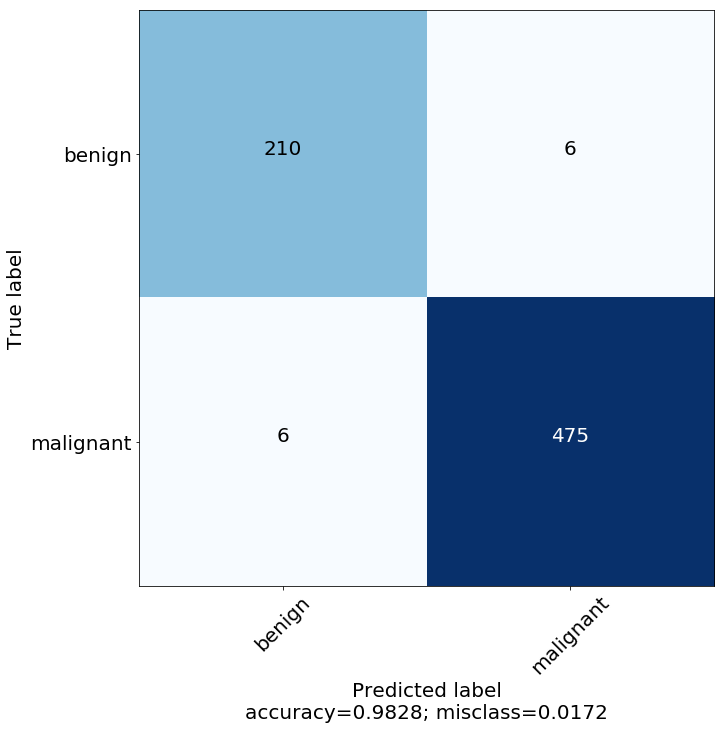

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[210   6]
 [  6 475]]
             precision    recall  f1-score   support

     benign       0.97      0.97      0.97       216
  malignant       0.99      0.99      0.99       481

avg / total       0.98      0.98      0.98       697



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  97.22222222222221
Specificity :  98.75259875259876


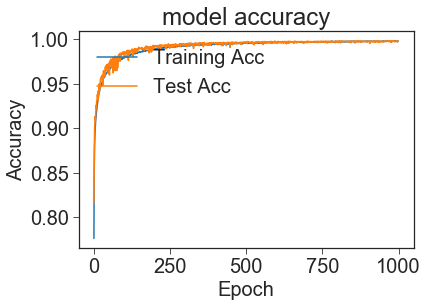

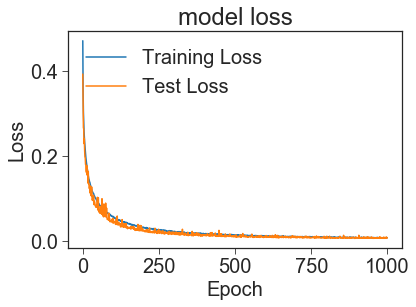

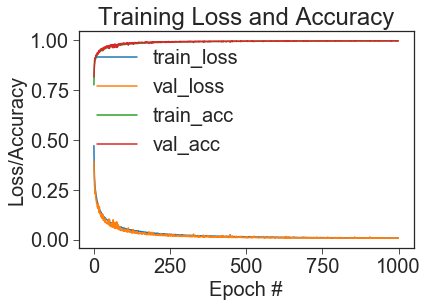

In [22]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")